In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import json
import pdb

from utils import create_dict, create_list, get_data, find_type2_locations, find_type3_locations, find_type4_locations
from utils import applyArtifacts, removeCells, avg_firing, NumpyEncoder, avg_amplitude, nrActiveCells, div_avg_firing, div_avg_amplitude, top_least
from utils import cellID, spindle_locs, search_spindle, spi_inOut_diff, zscore_calculator
from Analyses_ import slo_spi
%config Completer.use_jedi = False

### Input informations

In [2]:
all_address = ['L:/analysis_nima/250520_m18a/Batch_4', 'L:/analysis_nima/290520_m17a/Batch/extracells/Batch_2',
                'L:/analysis_nima/110620_m18b/new/Batch_3', 'L:/analysis_nima/050820_m21a/Batch_4',
                'L:/analysis_nima/030720_m20a/Batch_3', 'L:/analysis_nima/291020_m23a/Batch_2', 
               'L:/analysis_nima/210121_m24a/Batch_1']

# sampling rate for different mice
sfs = [30.995, 30.995, 30.955, 30.995, 30.995, 30.9576, 30.995]

# defining artifacts
custom_artifacts_1 = [[11007,11008,4]]
custom_artifacts_2 = [[11630,11947,0],[12000,12700,0],[4533,5154,14]]
custom_artifacts_3 = []
custom_artifacts_4 = [[1595,1845,0],[4609,4907,0],[7740,7983,0],[13795,14101,0],[16706,16973,0],
             [7266,7501,1],[11912,12219,1],[12703,13203,1],[13730,13909,1],[15097,15559,1],[17277,17519,1],
             [1416,1793,2],[3816,4123,2],[13254,13593,2],[15224,15703,2],[17668,18067,2],
             [7358,7521,3],[10240,10253,3],[13672,13748,3],[17306,17593,3],
             [5505,5939,4],[6222,6231,4],[16760,16820,4],[18450,18573,4],                           
             [1132,1357,7],[8653,8776,7],[9946,10391,7],
             [9068,9323,7],[13589,13623,7],[17394,17547,7],
             [1,140,8],[908,965,8],[7638,7665,8],[8014,8027,8],[14726,14922,8],[18022,18187,8],
             [1912,2381,9],[2920,2923,9],[7767,7819,9],[7864,7997,9],[9876,10197,9],[15206,15545,9],
             [6734,7220,10],[9668,9939,10],
             [8914,9290,11],[9562,9571,11],[12216,12339,11],
             [11492,11553,12],[13898,13919,12],
             [6298,6619,13],[12282,12795,13],[14406,14507,13],[14798,14875,13],
             [1,220,14],[1878,2108,14],[9872,9961,14],
             [4764,4813,15],[5564,5571,15],[15419,15595,15],[16003,16089,15],[16420,16482,15],
             [4240,4403,16],[9975,10077,16],[10274,10275,16],[13228,13451,16],[13805,13939,16],[14620,14664,16],[15764,15857,16],[18430,18537,16],
             [10425,10591,17],[11058,11709,17],[12232,12311,17],[12784,12804,17],[17000,17115,17],
             [10655,10825,18],[11993,12075,18],[12648,12685,18],[16013,16134,18],
             [14466,15015,19],[16876,17009,19],[18398,18573,19],
            [628,958,23],[7822,7976,23],[10298,10435,23],[13899,14241,23],[14466,14537,23],[15773,15848,23],[17664,17925,23],[18291,18426,23],
            [4309,4512,24],[5271,5467,24],[6450,6700,24],[7186,7593,24],
            [460,700,25],[1714,1725,25],[4045,4153,25],[13600,13699,25],
            [4434,4568,26],[5984,6167,26],
            [1770,1831,27],[4060,4064,27],
            [2000,2193,28],[11098,11334,28],
            [5921,5997,30],[8200,8210,30],[9189,9191,30],
            [686,852,31],[13375,13543,31],[14059,14334,31],[15808,15883,31],
            [10760,10800,33],[13942,14061,33],[17672,17738,33],
            [10576,10604,41]]
custom_artifacts_5 = [[3928,3971,0],[4584,4656,0],[7001,7119,0],[14144,14230,0],[14466,14501,0],[15591,15593,0],
            [559,603,1],[2187,2214,1],[3999,4054,1],[11749,11790,1],[17785,17839,1],
            [3403,3491,2],[11936,11980,2],
            [1397,1465,3],[13881,13889,3],[14510,14526,3],[18377,18441,3],                                                                                           
            [2585,2635,4], [6722,6771,4],[10867,10897,4],[16543,16615,4],
            [740,825,5],[2026,2113,5],[13025,13051,5],
            [798,863,6],[1795,1857,6],[3949,3980,6],[5190,5244,6],[10480,10547,6],[11219,11301,6],[12144,12191,6],[12690,12747,6],
            [1343,1441,7],[2618,2684,7],[2709,2713,7],[3427,3496,7],[4138,4185,7],[4532,4567,7],[5694,8768,7],[9513,9562,7],[12510,12644,7],[15000,15073,7],
            [96,140,8],[4175,4258,8],
            [409,564,9],[13291,13497,9],[16520,18573,9],
            [9968,10026,10],[14269,14335,10],[16569,16616,10],
            [404,557,11],[12553,12649,11],
            [503,598,13],[2832,2889,13],[13151,13218,13],[18276,18343,13],
            [769,954,14],[980,1001,14],[2324,2389,14],[4286,4297,14],
            [3349,3447,15],[6128,6221,15],
            [8475,8543,16],
            [9792,9840,17],
            [2984,3007,20],[4131,4183,20],[5025,5042,20],[6330,6355,20],[11818,11893,20],
            [6760,6875,21],
            [12871,12895,28],[13645,13667,28],[14232,14319,28],[14837,14849,28],[15521,15542,28],[16421,16445,28],[17032,17040,28]]
custom_artifacts_6 = [[8863,9191,4],
           [5389,5393,7],[5575,5607,7],[5754,5755,7],[5798,6000,7],
            [11050,11070,10],[12260,12280,10],
            [15125,15290,12],[16420,18160,10],
            [13280,13340,13],
            [8,23,15],[92,94,15],[481,505,15],
            [10035,10500,20],[11024,11044,20],
            [5794,5800,21],
            [3501,3507,22]]
custom_artifacts_7 = [[0,3418,0],[13116,13507,0],[14502,14872,0],
              [8000,9000,2],
              [1828,2638,3],[8631,12630,3],
              [1497,1988,4],[16470,17270,4],
              [5113,8239,5],                                                                                         
              [2322,2978,6],
              [12460,14890,7],
              [15600,16060,10],
              [4231,4848,11],[6434,6909,11],[9110,11550,11],
              [11890,12380,12],
              [8410,8820,13],
              [3026,3515,14],[13810,14170,14],
              [10910,12010,15]]  
artifacts = [custom_artifacts_1, custom_artifacts_2, custom_artifacts_3,
                custom_artifacts_4, custom_artifacts_5, custom_artifacts_6, custom_artifacts_7]

# cell removal 
remove_cell_1 = []
remove_cell_2 = []
remove_cell_3 = [62,63,64,65,66,67,68,69,70,80,81,160,161,162,163,164,167,194,195,202,203,204]
remove_cell_4 = [13,53,55,57,79,84,85,86,95,99,112,141,144,147,153,177,178,183,184,188,189,191,196,197,198,199,202,219,226,234,235]
remove_cell_5 = []
remove_cell_6 = [66,84,85,86]
remove_cell_7 = []
remove_cells = [remove_cell_1, remove_cell_2, remove_cell_3,
              remove_cell_4, remove_cell_5, remove_cell_6, remove_cell_7]
# mouse name
miceName = ['250520_m18a', '290520_m17a', '110620_m18b', '050820_m21a', '030720_m20a', '291020_m23a', '210121_m24a']

# mouse name indcies
mouse_index = {miceName[0]:0, miceName[1]:1, miceName[2]:2, miceName[3]:3, miceName[4]:4, miceName[5]:5, miceName[6]:6}


# saving figure 
save_fig = True # or False
fig_save_add = ''


# saving dataframes
save_file = True # or False
file_save_add = ''

### Creating base data structure and loading data and hypno to it
####    If ncessary first apply artifact on data or remove cells then create data structure

In [3]:
apply_artifact = True
rmCell = True

data_list = []
for address, sf, mouse_name, artifact, remove_cell in zip(all_address, sfs, miceName, artifacts, remove_cells):
    
    #clear and read data
    data = []; hypno = []
    data, hypno = get_data(address = address, sf = sf)
    
    if apply_artifact:
        data = applyArtifacts(data=data, artifacts=artifact)
    
    if rmCell:
        data = removeCells(data=data, cells = remove_cell)
    
    # creat per mouse list
    data_list.extend(create_list(data = data, hypno = hypno, mouseName = mouse_name, 
                                 sf = sf, apply_artifact=apply_artifact, removeCell=rmCell))

Your entered path is L:/analysis_nima/250520_m18a/Batch_4
All files in the given path 

['unit01.mat', 'unit02.mat', 'unit03.mat', 'unit04.mat', 'unit05.mat', 'unit06.mat', 'unit07.mat', 'unit08.mat', 'unit09.mat', 'unit10.mat', 'unit11.mat', 'unit12.mat', 'unit13.mat', 'unit14.mat', 'unit15.mat', 'unit16.mat', 'unit17.mat', 'unit18.mat', 'unit19.mat', 'unit20.mat', 'unit21.mat', 'unit22.mat', 'unit23.mat', 'unit24.mat', 'unit25.mat', 'unit26.mat', 'unit27.mat', 'unit28.mat', 'unit29.mat', 'unit30.mat', 'unit31.mat', 'unit32.mat', 'unit33.mat', 'unit34.mat', 'unit35.mat', 'unit36.mat', 'unit37.mat', 'unit38.mat', 'unit39.mat', 'unit40.mat', 'unit41.mat', 'unit42.mat', 'unit43.mat', 'unit44.mat', 'unit45.mat']  Number of all files 45
Data are loaded 

Start reading units 

unit length is 600 sec, data length is 18597 samples, number of cells are 236 

Finished reading units 

Start reading hypno files 

Finished reading hypno 

Location-Time information
data and hypno shapes in file L:/

### Adding analyses as dictionary key, value pairs

In [4]:
# add average firing rate to the dictionary
[data_dict.update({'avg_firing_perSecond':avg_firing(data = data_dict['data'], 
                                                            sf=data_dict['samplingRate'])}) for data_dict in data_list];

In [5]:
# add average amplitude to the dictionary
[data_dict.update({'avg_amplitude':avg_amplitude(data = data_dict['data'])}) for data_dict in data_list];

c:\Users\admin\Sleep_Pipeline_Notebooks\Analysis_all_mice\SleepAnalyses\utils.py:227: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.where(data>0 , data, np.nan), axis = 0)


In [ ]:
# zscore normalization of avg firing rate. Normalization is applied per cell for each individual mouse separately
data_list = zscore_calculator(dataBase = data_list, mouse_name_list=miceName, variable = "frequency")

# zscore normalization of avg amplitude. Normalization is applied per cell for each individual mouse separately
data_list = zscore_calculator(dataBase = data_list, mouse_name_list=miceName, variable = "amplitude")


In [6]:
# add top and least firing rate 
fraction = 20

#top
[data_dict.update({'top' + str(fraction) + '_avg_firing':top_least(data=data_dict['avg_firing_perSecond'], 
                                                                   prc = fraction, top = True)}) for data_dict in data_list];

#least
[data_dict.update({'least' + str(fraction) + '_avg_firing':top_least(data=data_dict['avg_firing_perSecond'], 
                                                                   prc = fraction, top = False)}) for data_dict in data_list];


#top-zscore
[data_dict.update({'top' + str(fraction) + '_avg_firing_zscore':top_least(data=data_dict['avg_firing_perSecond_zscore'], 
                                                                   prc = fraction, top = True)}) for data_dict in data_list];

#least-zscore
[data_dict.update({'least' + str(fraction) + '_avg_firing_zscore':top_least(data=data_dict['avg_firing_perSecond_zscore'], 
                                                                   prc = fraction, top = False)}) for data_dict in data_list];

In [7]:
# add top and least amplitude 
fraction = 20

#top
[data_dict.update({'top' + str(fraction) + '_amplitude':top_least(data=data_dict['avg_amplitude'], 
                                                                   prc = fraction, top = True)}) for data_dict in data_list];

#least
[data_dict.update({'least' + str(fraction) + '_amplitude':top_least(data=data_dict['avg_amplitude'], 
                                                                   prc = fraction, top = False)}) for data_dict in data_list];


#top-zscore
[data_dict.update({'top' + str(fraction) + '_amplitude_zscore':top_least(data=data_dict['avg_amplitude_zscore'], 
                                                                   prc = fraction, top = True)}) for data_dict in data_list];

#least-zscore
[data_dict.update({'least' + str(fraction) + '_amplitude_zscore':top_least(data=data_dict['avg_amplitude_zscore'], 
                                                                   prc = fraction, top = False)}) for data_dict in data_list];

In [8]:
# add divided average firing rate to the dictionary
[data_dict.update({'div_avg_firing_perSecond':div_avg_firing(data = data_dict['data'], 
                                                             sf=data_dict['samplingRate'], 
                                                             n = 3)}) for data_dict in data_list];

# zscore normalization of avg firing rate. Normalization is applied per cell for each individual mouse separately
data_list = zscore_calculator(dataBase = data_list, mouse_name_list=miceName, variable = "frequency", divided_data=True)

In [9]:
# add divided average firing rate to the dictionary (n subdata)
[data_dict.update({'div_avg_amplitude':div_avg_amplitude(data = data_dict['data'], n=3)}) for data_dict in data_list];

# zscore normalization of avg amplitude. Normalization is applied per cell for each individual mouse separately
data_list = zscore_calculator(dataBase = data_list, mouse_name_list=miceName, variable = "amplitude", divided_data= True)

In [10]:
# add epoch duration in sample
[data_dict.update({'epochDuration': data_dict['data'].shape[0]}) for data_dict in data_list];

In [11]:
# add nr of active cell per epoch
[data_dict.update({'nrActiveCells': nrActiveCells(data = data_dict['avg_amplitude'])}) for data_dict in data_list];

In [12]:
# add nr of total cells per epoch
[data_dict.update({'nrTotalCells': data_dict['data'].shape[1]}) for data_dict in data_list];

In [13]:
# adding location of type2 pattern to the dictionaries


# type2: 1 epoch is first element of the pattern
#        2 epoch is second element of the pattern
#        0 epoch is not involved in the pattern


# finding locations (each location is the location of first element of the pattern)
type2_locations = find_type2_locations(dictLists=data_list, pattern=[-2, -3], 
                                       cond1_min= 900, cond1_max=10000, 
                                       cond2_min=900, cond2_max=10000)



[data_dict.update({'type2': 0}) for data_dict in data_list]

for i, data_dict in enumerate(data_list):
    if i in type2_locations:
        data_dict.update({'type2':1})
        data_list[i+1].update({'type2':2})

In [14]:
# adding location of type3 pattern to the dictionaries


# type2: 1 epoch is first element of the pattern
#        2 epoch is second element of the pattern
#        3 epoch is third element of the pattern
#        0 epoch is not involved in the pattern


# finding locations (each location is the location of first element of the pattern)
type3_locations = find_type3_locations(dictLists=data_list, pattern=[-2, -3, -2], 
                                       cond1_min=900, cond1_max=10000, 
                                       cond2_min=900, cond2_max=10000, 
                                       cond3_min=900, cond3_max=10000)



[data_dict.update({'type3': 0}) for data_dict in data_list]

for i in range(type3_locations.shape[0]):
    
    # put all pattern locations in the first element of the pattern
    data_list[type3_locations[i,0]].update({'type3':type3_locations[i,:]})
    

In [15]:
# adding location of type4 pattern to the dictionaries


# type2: 1 epoch is first element of the pattern
#        2 epoch is second element of the pattern
#        3 epoch is third element of the pattern
#        0 epoch is not involved in the pattern


# finding locations (each location is the location of first element of the pattern)
type4_locations = find_type4_locations(dictLists=data_list, pattern=[0, -2, 0, -2], 
                                       cond1_min= 900, cond1_max=10000, 
                                       cond2_min=900, cond2_max=10000, 
                                       cond3_min=900, cond3_max=10000,
                                       cond4_min=900, cond4_max=10000)



[data_dict.update({'type4': 0}) for data_dict in data_list]

for i in range(type4_locations.shape[0]):
    
    # put all pattern locations in the first element of the pattern
    data_list[type4_locations[i,0]].update({'type4':type4_locations[i,:]})
    

In [16]:
# top x % based RTM issue for type2/type3 patterns

# type2_avgFiring_RTM: normalized firing rate of 2 type2 epochs (concatinating 2 epochs)
# type3_avgFiring_RTM: normalized firing rate per cell taking all 3 type3 epochs together (concatinating 3 epochs)

# type2_topx%_RTM: top x% of normalized firing rate cells based on type2 (taking average from above-it always comes to the first epoch)
# type3_topx%_RTM: top x% of normalized firing rate cells based on type3 (taking average from above-it alwaves comes to the first epoch)

# initializing values
[data_dict.update({"type2_avgFiring_RTM": None}) for data_dict in data_list]
[data_dict.update({"type3_avgFiring_RTM": None}) for data_dict in data_list]

[data_dict.update({f"type2_top{fraction}%_RTM": None}) for data_dict in data_list]
[data_dict.update({f"type3_top{fraction}%_RTM": None}) for data_dict in data_list]

[data_dict.update({f"type2_least{fraction}%_RTM": None}) for data_dict in data_list]
[data_dict.update({f"type3_least{fraction}%_RTM": None}) for data_dict in data_list]

print("Start main analyses\nRun 1")

for i, epoch in enumerate(data_list):
    
    # check first type2 epoch
    if epoch["type2"] == 1:
        # calculate type2_avgFiring_RTM
        epoch["type2_avgFiring_RTM"] = avg_firing(data = np.vstack([epoch["data"], data_list[i+1]["data"]]), 
                                                  sf = epoch["samplingRate"])
        
    if not isinstance(epoch["type3"], int):
        # calculate type3_avgFiring_RTM
        epoch["type3_avgFiring_RTM"] = avg_firing(data = np.vstack([data_list[epoch["type3"][0]]["data"], 
                                                                    data_list[epoch["type3"][1]]["data"], 
                                                                    data_list[epoch["type3"][2]]["data"]]), 
                                                  sf = epoch["samplingRate"])

print("Run 2")
for i, epoch in enumerate(data_list):
    
    # check first type2 epoch
    if epoch["type2"] == 1:
        # calculate type2_topx%_RTM
        epoch[f"type2_top{fraction}%_RTM"] = top_least(data = epoch["type2_avgFiring_RTM"], prc = fraction, top = True)
        epoch[f"type2_least{fraction}%_RTM"] = top_least(data = epoch["type2_avgFiring_RTM"], prc = fraction, top = False)
        
    if not isinstance(epoch["type3"], int):
        # calculate type3_topx%_RTM
        epoch[f"type3_top{fraction}%_RTM"] = top_least(data = epoch["type3_avgFiring_RTM"], prc = fraction, top = True)
        epoch[f"type3_least{fraction}%_RTM"] = top_least(data = epoch["type3_avgFiring_RTM"], prc = fraction, top = False)


Start main analyses
Run 1
Run 2


### Spindle/Slow Oscillations

In [17]:
spi_slow_use = True

# main file adrress (Niels data)
spi_slow_file_address = ['L:/analysis_nima/spindles/m18a.mat', 'L:/analysis_nima/spindles/m17a.mat', 
                        'L:/analysis_nima/spindles/m18b.mat', 'L:/analysis_nima/spindles/m21a.mat', 
                        'L:/analysis_nima/spindles/m20a.mat', 'L:/analysis_nima/spindles/m23a.mat', 
                        'L:/analysis_nima/spindles/m24a.mat']
# location of events in selected file (can be spindle or slow oscillation)
spi_slow_data_loc = 'Results/slo/events'

# start and end index (in spindle is 0-1 but in slow oscillation is 1-2)
spi_slow_start_index = 1
spi_slow_end_index = 2

# channel number we want to select ([0,0] or [0,1] - frontal or parietal)
spi_slow_channel_nr = [0,0]

# address for files with unit information
spi_slow_start_end_unit_address = ['L:/analysis_nima/250520_m18a/hypno_unit_sec_m18a.csv', 
                                   'L:/analysis_nima/290520_m17a/Batch/hypno_unit_sec_m17a.csv', 
                                   'L:/analysis_nima/110620_m18b/hypno_unit_sec_m18b.csv', 
                                   'L:/analysis_nima/050820_m21a/hypno_unit_sec_m21a.csv', 
                                   'L:/analysis_nima/030720_m20a/hypno_unit_sec_m20a.csv', 
                                   'L:/analysis_nima/291020_m23a/hypno_unit_sec_m23a.csv', 
                                   'L:/analysis_nima/210121_m24a/hypno_unit_sec_m24a.csv']


# Binary indicator to do coupled analysis or take all spindles (True only for spindles. Must be False for slow oscillation)
spi_slow_apply_couple = False

# When apply_couple is True this is indicator to select only coupled spindles (True) or non-coupled spindles (False)
spi_slow_couple_analysis = False

# channels number to select from coupled spindles ([0,0] or [0,1] - frontal or parietal)
spi_slow_couple_channel = [0,0]

# location of coupled spindles indices
spi_slow_couple_address = '/Results/slospi/spiIndx'

In [18]:
spi_slo_art_all = []
for i in range(len(spi_slow_file_address)):
    slow_osc = slo_spi(file_address=spi_slow_file_address[i], 
                       data_location=spi_slow_data_loc, channel_nr=spi_slow_channel_nr, 
                       start_index=spi_slow_start_index, end_index=spi_slow_end_index, 
                       start_end_file_add=spi_slow_start_end_unit_address[i], 
                       file_length= int(3e7), elec_sample=1000, unit_length=600, ca_fs=sfs[i], 
                       coupled = {'apply':spi_slow_apply_couple, 'address':spi_slow_couple_address, 
                                  'channel':spi_slow_couple_channel, 'cp':spi_slow_couple_analysis})
    print(f'running file {spi_slow_file_address[i]}')
    spi_slo_art_all.append(slow_osc.slo_spi_list())

running file L:/analysis_nima/spindles/m18a.mat
running file L:/analysis_nima/spindles/m17a.mat
running file L:/analysis_nima/spindles/m18b.mat
running file L:/analysis_nima/spindles/m21a.mat
running file L:/analysis_nima/spindles/m20a.mat
running file L:/analysis_nima/spindles/m23a.mat
running file L:/analysis_nima/spindles/m24a.mat


In [19]:
# adding spindle/oscillation data to database

# initializing data and indices
[data_dict.update({'spi_osc_data': []}) for data_dict in data_list];
[data_dict.update({'spi_osc_indices': []}) for data_dict in data_list];
[data_dict.update({'spi_osc_NOTdata': []}) for data_dict in data_list];
[data_dict.update({'spi_osc_NOTindices': []}) for data_dict in data_list];

# running analyses (data)
[data_dict.update({'spi_osc_data': search_spindle(data_spindle=spi_slo_art_all, Dict=data_dict, mouse_index=mouse_index)[0]}) for data_dict in data_list];

# running analyses (indices)
[data_dict.update({'spi_osc_indices': search_spindle(data_spindle=spi_slo_art_all, Dict=data_dict, mouse_index=mouse_index)[1]}) for data_dict in data_list];

# running analyses (NOTdata: data outside of spindle range)
[data_dict.update({'spi_osc_NOTdata': search_spindle(data_spindle=spi_slo_art_all, Dict=data_dict, mouse_index=mouse_index)[2]}) for data_dict in data_list if len(data_dict['spi_osc_data'])];


# running analyses (NOTindices)
[data_dict.update({'spi_osc_NOTindices': search_spindle(data_spindle=spi_slo_art_all, Dict=data_dict, mouse_index=mouse_index)[3]}) for data_dict in data_list];

In [20]:
# adding avg_firing rate for spi/osc and not spi/osc time periods

# initializing
[data_dict.update({'spi_osc_data_avgFiring': []}) for data_dict in data_list];
[data_dict.update({'spi_osc_NOTdata_avgFiring': []}) for data_dict in data_list];

[data_dict.update({'spi_osc_data_avgAmplitude': []}) for data_dict in data_list];
[data_dict.update({'spi_osc_NOTdata_avgAmplitude': []}) for data_dict in data_list];

# calculating average

[data_dict.update({'spi_osc_data_avgFiring': avg_firing(data = np.vstack(data_dict['spi_osc_data']), 
                                                            sf=data_dict['samplingRate'])}) for data_dict in data_list if len(data_dict['spi_osc_data'])];

[data_dict.update({'spi_osc_NOTdata_avgFiring': avg_firing(data = data_dict['spi_osc_NOTdata'], 
                                                            sf=data_dict['samplingRate'])}) for data_dict in data_list if len(data_dict['spi_osc_NOTdata'])];

[data_dict.update({'spi_osc_data_avgAmplitude': avg_amplitude(data = np.vstack(data_dict['spi_osc_data']))}) for data_dict in data_list if len(data_dict['spi_osc_data'])];

[data_dict.update({'spi_osc_NOTdata_avgAmplitude': avg_amplitude(data = data_dict['spi_osc_NOTdata'])}) for data_dict in data_list if len(data_dict['spi_osc_NOTdata'])];

In [21]:
# add top and least firing rate 
fraction = 20

#top
[data_dict.update({'spindle_top' + str(fraction) + '_diff_firing':top_least(data=spi_inOut_diff(x = data_dict['spi_osc_data_avgFiring'], 
                                                                                                y = data_dict['spi_osc_NOTdata_avgFiring']), 
                                                                   prc = fraction, top = True)}) for data_dict in data_list if len(data_dict['spi_osc_data'])];

#least
[data_dict.update({'spindle_least' + str(fraction) + '_diff_firing':top_least(data=spi_inOut_diff(x = data_dict['spi_osc_data_avgFiring'], 
                                                                                                  y = data_dict['spi_osc_NOTdata_avgFiring']), 
                                                                   prc = fraction, top = False)}) for data_dict in data_list if len(data_dict['spi_osc_data'])];

In [22]:
# number of spindle active cells per epoch

# initialize
[data_dict.update({'nrSpindleActiveCells': []}) for data_dict in data_list];

# calculate 
[data_dict.update({'nrSpindleActiveCells': len(np.where(~np.isnan(data_dict["spi_osc_data_avgFiring"]))[0])}) for data_dict in data_list if len(data_dict["spi_osc_data_avgFiring"])];

In [23]:
# normalized (to total active cells in epoch-in percentage) fraction of spindle active cells per epoch

# initialize
[data_dict.update({'norm_SpindleActiveCells': []}) for data_dict in data_list];

# calculate 
[data_dict.update({'norm_SpindleActiveCells': (len(np.where(~np.isnan(data_dict["spi_osc_data_avgFiring"]))[0]) / data_dict["nrActiveCells"]) * 100}) for data_dict in data_list if len(data_dict["spi_osc_data_avgFiring"])];

In [24]:
# normalized (to total active cells in epoch-in percentage) fraction of spindle active cells per epoch

# initialize
[data_dict.update({'normTototal_SpindleActiveCells': []}) for data_dict in data_list];

# calculate 
[data_dict.update({'normTototal_SpindleActiveCells': (len(np.where(~np.isnan(data_dict["spi_osc_data_avgFiring"]))[0]) / data_dict["nrTotalCells"]) * 100}) for data_dict in data_list if len(data_dict["spi_osc_data_avgFiring"])];

In [ ]:
############################################################################################
############################################################################################

In [ ]:
# plotting average firing rate 

df_nr_spindle_active_cells = pd.DataFrame()


for i, indDict in enumerate(data_list):
    if indDict['nrSpindleActiveCells']:
        df_nr_spindle_active_cells = df_nr_spindle_active_cells.append(pd.DataFrame({'state':[indDict['hypnoState']], 
                                                                   'nr_active_cells':[indDict['nrSpindleActiveCells']], 
                                                                   'norm_active_cells':[indDict['norm_SpindleActiveCells']],
                                                                   'normTototal_active_cells':[indDict['normTototal_SpindleActiveCells']],
                                                                   'nr_unit':[indDict['unitNr']], 
                                                                   'name':indDict['mouseName']}), ignore_index = True)


# Plotting of analyses

### overlap spindle-active/inactive top/least during sws (Triplet3)

In [ ]:
### Fraction for all epochs of SWS with spindles for SWSn-REM-SWSn+1


df_spindle_firing = pd.DataFrame()


for i, indDict in enumerate(data_list):
    if (not isinstance(indDict['type3'], int)) and (len(indDict['spi_osc_data'])):
        temp_spi = []
        temp_least = []
        temp_spi = indDict["spindle_least20_diff_firing"][0]
        temp_least = indDict["least20_avg_firing"][0]
        
        df_spindle_firing = df_spindle_firing.append(pd.DataFrame({'Fraction':[(len([d for d in temp_spi if d in temp_least])/len(temp_spi)) *100], 
                                                             'name':indDict['mouseName'], 
                                                             'epochID': i}), ignore_index = True)
    

### overlap spindle-active/inactive top/least during sws 

In [ ]:
### Fraction for all epochs of SWS with spindles
df_spindle_firing = pd.DataFrame()


for i, indDict in enumerate(data_list):
    if (len(indDict['spi_osc_data'])):
        temp_spi = []
        temp_least = []
        temp_spi = indDict["spindle_least20_diff_firing"][0]
        temp_least = indDict["least20_avg_firing"][0]
        
        df_spindle_firing = df_spindle_firing.append(pd.DataFrame({'Fraction':[(len([d for d in temp_spi if d in temp_least])/len(temp_spi)) *100], 
                                                             'name':indDict['mouseName'], 
                                                             'epochID': i}), ignore_index = True)

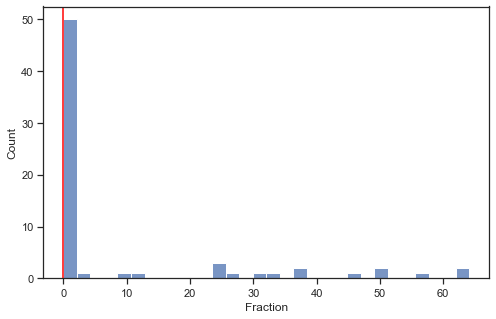

In [ ]:
sns.histplot(data = df_spindle_firing, x = "Fraction", bins=30)
plt.axvline(x=df_spindle_firing.Fraction.median(),
            color='red')
#plt.xlim(-5,90)


In [ ]:

spindle_active_cells=df_spindle_firing[df_spindle_firing.Pattern==1]
#del df_spindle_firing["Pattern"]
del spindle_active_cells["Pattern"]
spindle_active_cells
if save_file:
    spindle_active_cells.to_csv(path_or_buf=file_save_add + 'L:/analysis_nima/statistics_epoch_based/slo_active_cells.csv')

In [ ]:
# RTM
df_spindle_firing = pd.DataFrame()


for i, indDict in enumerate(data_list):
    if (not isinstance(indDict['type3'], int)) and (len(indDict['spi_osc_data'])):
        temp_spi = []
        temp_least = []
        temp_spi = indDict["spindle_top20_diff_firing"][0]
        temp_least = indDict["type3_least20%_RTM"][0]
        
        df_spindle_firing = df_spindle_firing.append(pd.DataFrame({'Fraction':[(len([d for d in temp_spi if d in temp_least])/len(temp_spi)) *100], 
                                                             'name':indDict['mouseName'], 
                                                             'epochID': i}), ignore_index = True)
    

In [ ]:
# RTM
df_spindle_firing = pd.DataFrame()


for i, indDict in enumerate(data_list):
    if (not isinstance(indDict['type3'], int)) and (len(indDict['spi_osc_data'])):
        temp_spi = []
        temp_least = []
        temp_spi = indDict["spindle_least20_diff_firing"][0]
        temp_least = indDict["type3_top20%_RTM"][0]
        
        df_spindle_firing = df_spindle_firing.append(pd.DataFrame({'Fraction':[(len([d for d in temp_spi if d in temp_least])/len(temp_spi)) *100], 
                                                             'name':indDict['mouseName'], 
                                                             'epochID': i}), ignore_index = True)
    

SyntaxError: invalid syntax (Temp/ipykernel_13048/1782171823.py, line 6)

In [ ]:
sns.histplot(data = df_spindle_firing, x = "Fraction", bins=30)
plt.axvline(x=df_spindle_firing.Fraction.median(),
            color='red')

ValueError: Could not interpret value `Fraction` for parameter `x`

### find least active cells during swsn (Triplet3 for all cells)

In [ ]:
# plotting average firing rate 

df_typ3_firing = pd.DataFrame()

    
for i, data_dict in enumerate(data_list):
    if not isinstance(data_dict['type3'], int):
        df_typ3_firing = df_typ3_firing.append(pd.DataFrame({'Cell_nr':data_list[data_dict['type3'][0]]['least10_avg_firing'][0],
                                                             'Second':data_list[data_dict['type3'][0]]['least10_avg_firing'][0],
                                                             'Third':data_list[data_dict['type3'][0]]['least10_avg_firing'][0],
                                                             'name':data_dict['mouseName'], 
                                                             'epochID': i}), ignore_index = True)
    
    

In [ ]:
del df_typ3_firing["Second"]
del df_typ3_firing["Third"]
df_typ3_firing

if save_file:
    df_typ3_firing.to_csv(path_or_buf=file_save_add + 'L:/analysis_nima/statistics_epoch_based/top_active_during_sws.csv')

### violin plot for spindle_active-spindle_inactive-top-least_active cells


In [ ]:
#### violin plot for spindle_active-spindle_inactive-top-least_active cells PER EPOCH

df_spindle_firing = pd.DataFrame()


for i, indDict in enumerate(data_list):
    if  (len(indDict['spi_osc_data'])):
        
        spi_top20 = []
        spi_least20= []
        all_top20 = []
        all_least20 = []
        all_cells =[]
        
        spi_top20 = np.nanmean(indDict["spindle_top20_diff_firing"][1])
        spi_least20= np.nanmean(indDict["spindle_least20_diff_firing"][1])
        all_cells = np.nanmean(indDict["avg_firing_perSecond"])
        all_least20 = np.nanmean(indDict["least20_avg_firing"][1])
        all_top20 = np.nanmean(indDict["top20_avg_firing"][1])
        
        df_spindle_firing = df_spindle_firing.append(pd.DataFrame({'spindle_top20':[spi_top20], 
                                                                   'spindle_least20':[spi_least20], 
                                                                   'all_cells':[all_cells],
                                                                   'all_least20':[all_least20], 
                                                                   'all_top20':[all_top20], 
                                                                   'name':indDict['mouseName']}), ignore_index = True)
    

In [ ]:
#### violin plot for spindle_active-spindle_inactive-top-least_active cells PER EPOCH

df_spindle_firing = pd.DataFrame()


for i, indDict in enumerate(data_list):
    if (not isinstance(indDict['type3'], int)) and (len(indDict['spi_osc_data'])):
        spi_top20 = []
        spi_least20= []
        all_top20 = []
        all_least20 = []
        all_cells =[]
        
        spi_top20 = np.nanmean(indDict["spindle_top20_diff_firing"][1])
        spi_least20= np.nanmean(indDict["spindle_least20_diff_firing"][1])
        all_cells = np.nanmean(indDict["avg_firing_perSecond"])
        all_least20 = np.nanmean(indDict["least20_avg_firing"][1])
        all_top20 = np.nanmean(indDict["top20_avg_firing"][1])
        
        df_spindle_firing = df_spindle_firing.append(pd.DataFrame({'spindle_top20':[spi_top20], 
                                                                   'spindle_least20':[spi_least20], 
                                                                   'all_cells':[all_cells],
                                                                   'all_least20':[all_least20], 
                                                                   'all_top20':[all_top20], 
                                                                   'name':indDict['mouseName']}), ignore_index = True)
    
    

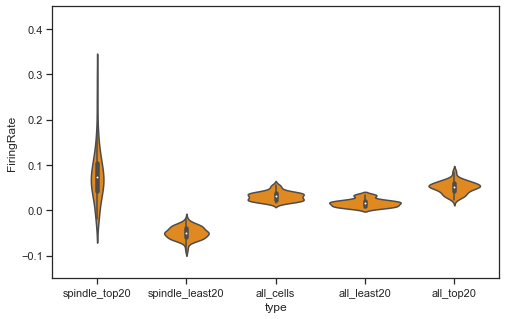

In [ ]:
df_temp = df_spindle_firing.melt(id_vars=['name'], var_name='type', value_name='FiringRate')
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("ticks")
plt.ylim(-0.15,0.45)
g=sns.violinplot(x="type", y="FiringRate",palette=['darkorange','darkorange','darkorange','darkorange','darkorange'],linewidth=1.5,data=df_temp )

#### marco trail

In [ ]:
### Fraction for all epochs of SWS with spindles
df_spindle_firing = pd.DataFrame()


for i, indDict in enumerate(data_list):
    if (len(indDict['spi_osc_data'])):
        temp_spi = []
        temp_top = []
        temp_least = []
        temp_spi = indDict["spindle_top20_diff_firing"][0]
        temp_top = indDict["top20_avg_firing"][0]
        temp_least = indDict["least20_avg_firing"][0]
        
        df_spindle_firing = df_spindle_firing.append(pd.DataFrame({'Fraction_with_least':[(len([d for d in temp_spi if d in temp_least])/len(temp_spi)) *100], 
                                                                   'Fraction_with_top':[(len([d for d in temp_spi if d in temp_top])/len(temp_spi)) *100],
                                                                   'name':indDict['mouseName'], 
                                                                   'epochID': i}), ignore_index = True)

Text(0.5, 0, 'Fraction_with_least')

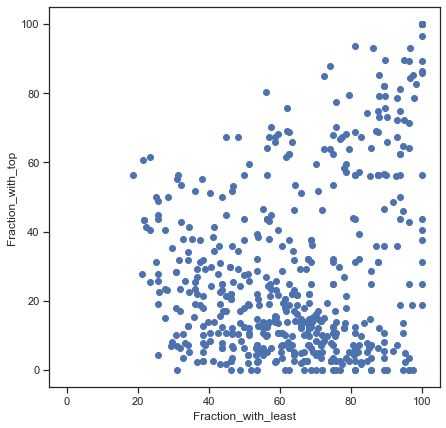

In [ ]:
plt.figure(figsize=(7,7))
plt.scatter(x="Fraction_with_least",
            y="Fraction_with_top", data=df_spindle_firing)

plt.ylim(-5,105)
plt.xlim(-5,105)
plt.ylabel('Fraction_with_top')
plt.xlabel('Fraction_with_least')


In [ ]:
##frequency without levels

# plotting average firing rate 

df_spindle_firing = pd.DataFrame()


for i, indDict in enumerate(data_list):
    if (not isinstance(indDict['type3'], int)) and (len(indDict['spi_osc_data'])):
        for ii in range(3):
            df_spindle_firing = df_spindle_firing.append(pd.DataFrame({'FiringRate':[np.nanmean(data_list[indDict['type3'][ii]]['avg_firing_perSecond'][data_list[indDict['type3'][0]]['spindle_top20_diff_firing'][0]])], 
                                                                 'name':indDict['mouseName'], 
                                                                 'Pattern': ii + 1, 
                                                                 'epochID': i}), ignore_index = True)

C:\Users\admin\AppData\Local\Temp/ipykernel_13048/1106199988.py:11: RuntimeWarning: Mean of empty slice
  df_spindle_firing = df_spindle_firing.append(pd.DataFrame({'FiringRate':[np.nanmean(data_list[indDict['type3'][ii]]['avg_firing_perSecond'][data_list[indDict['type3'][0]]['spindle_top20_diff_firing'][0]])],


In [ ]:
[indDict['avg_firing_perSecond'][data_list[indDict['spindle_top20_diff_firing'][0]]

SyntaxError: unexpected EOF while parsing (Temp/ipykernel_13048/3850389696.py, line 1)

### marco trail

In [ ]:
#### violin plot for spindle_active-spindle_inactive-top-least_active cells PER EPOCH

df_spindle_firing = pd.DataFrame()


for i, indDict in enumerate(data_list):
    if (not isinstance(indDict['type3'], int)) and (len(indDict['spi_osc_data'])):
        spi_top20 = []
        spi_least20= []
        all_top20 = []
        all_least20 = []
        all_cells =[]
        
        spi_top20 = np.nanmean(indDict['avg_firing_perSecond'][indDict['spindle_top20_diff_firing'][0]])
        spi_least20= np.nanmean(indDict['avg_firing_perSecond'][indDict['spindle_least20_diff_firing'][0]])
        all_cells = np.nanmean(indDict["avg_firing_perSecond"])
        all_least20 = np.nanmean(indDict["least20_avg_firing"][1])
        all_top20 = np.nanmean(indDict["top20_avg_firing"][1])
        
        df_spindle_firing = df_spindle_firing.append(pd.DataFrame({'spindle_top20':[spi_top20], 
                                                                   'spindle_least20':[spi_least20], 
                                                                   'all_cells':[all_cells],
                                                                   'all_least20':[all_least20], 
                                                                   'all_top20':[all_top20], 
                                                                   'name':indDict['mouseName']}), ignore_index = True)

In [ ]:
#### violin plot for spindle_active-spindle_inactive-top-least_active cells PER EPOCH

df_spindle_firing = pd.DataFrame()


for i, indDict in enumerate(data_list):
    if (len(indDict['spi_osc_data'])):
        spi_top20 = []
        spi_least20= []
        all_top20 = []
        all_least20 = []
        all_cells =[]
    
        spi_top20 = np.nanmean(indDict['avg_firing_perSecond'][indDict['spindle_top20_diff_firing'][0]])
        spi_least20= np.nanmean(indDict['avg_firing_perSecond'][indDict['spindle_least20_diff_firing'][0]])
        all_cells = np.nanmean(indDict["avg_firing_perSecond"])
        all_least20 = np.nanmean(indDict["least20_avg_firing"][1])
        all_top20 = np.nanmean(indDict["top20_avg_firing"][1])
        
        df_spindle_firing = df_spindle_firing.append(pd.DataFrame({'spindle_top20':[spi_top20], 
                                                                   'spindle_least20':[spi_least20], 
                                                                   'all_cells':[all_cells],
                                                                   'all_least20':[all_least20], 
                                                                   'all_top20':[all_top20], 
                                                                   'name':indDict['mouseName']}), ignore_index = True)
    
    

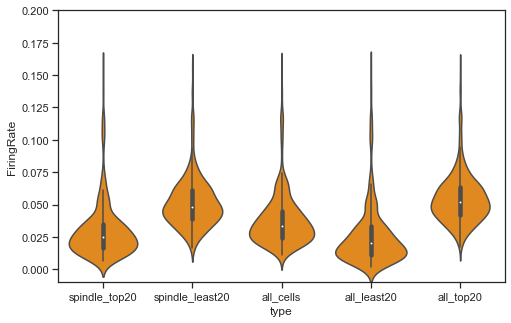

In [ ]:
df_temp = df_spindle_firing.melt(id_vars=['name'], var_name='type', value_name='FiringRate')
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("ticks")
plt.ylim(-0.01,0.2)
g=sns.violinplot(x="type", y="FiringRate",palette=['darkorange','darkorange','darkorange','darkorange','darkorange'],linewidth=1.5,data=df_temp )
#if save_file:
   # df_temp.to_csv(path_or_buf=file_save_add + 'L:/analysis_nima/statistics_epoch_based/distribition_firing_rate_subgroups/firing_rate_distribution_top20_swsn.csv')

In [ ]:
#### violin plot for spindle_active-spindle_inactive-top-least_active cells PER EPOCH

df_spindle_firing = pd.DataFrame()


for i, indDict in enumerate(data_list):
    if (epoch["hypnoState"] == -2 )and(len(indDict['spi_osc_data'])):
        spi_top20 = []
        spi_least20= []
        all_top20 = []
        all_least20 = []
        all_cells =[]
        
        spi_top20 = np.nanmean(indDict['avg_firing_perSecond'][indDict['spindle_top20_diff_firing'][0]])
        spi_least20= np.nanmean(indDict['avg_firing_perSecond'][indDict['spindle_least20_diff_firing'][0]])
        all_cells = np.nanmean(indDict["avg_firing_perSecond"])
        all_least20 = np.nanmean(indDict["least20_avg_firing"][1])
        all_top20 = np.nanmean(indDict["top20_avg_firing"][1])
        
        df_spindle_firing = df_spindle_firing.append(pd.DataFrame({'spindle_top20':[spi_top20], 
                                                                   'spindle_least20':[spi_least20], 
                                                                   'all_cells':[all_cells],
                                                                   'all_least20':[all_least20], 
                                                                   'all_top20':[all_top20], 
                                                                   'name':indDict['mouseName']}), ignore_index = True)
    
    

In [ ]:
#### violin plot for spindle_active-spindle_inactive-top-least_active cells PER EPOCH

df_spindle_firing = pd.DataFrame()


for i, indDict in enumerate(data_list):
    if (not isinstance(indDict['type3'], int)) and (len(indDict['spi_osc_data']) and (epoch["hypnoState"] == -2)) :
        spi_top20 = []
        spi_least20= []
        all_top20 = []
        all_least20 = []
        all_cells =[]
        
        spi_top20 = np.nanmean(indDict['avg_firing_perSecond'][indDict['spindle_top20_diff_firing'][0]])
        spi_least20= np.nanmean(indDict['avg_firing_perSecond'][indDict['spindle_least20_diff_firing'][0]])
        all_cells = np.nanmean(indDict["avg_firing_perSecond"])
        all_least20 = np.nanmean(indDict["least20_avg_firing"][1])
        all_top20 = np.nanmean(indDict["top20_avg_firing"][1])
        
        df_spindle_firing = df_spindle_firing.append(pd.DataFrame({'spindle_top20':[spi_top20], 
                                                                   'spindle_least20':[spi_least20], 
                                                                   'all_cells':[all_cells],
                                                                   'all_least20':[all_least20], 
                                                                   'all_top20':[all_top20], 
                                                                   'name':indDict['mouseName']}), ignore_index = True)

### Prova

###### Frequency for spindle active/inactive not overlapping with top/least


In [ ]:
### Frequency for spindle active/inactive not overlapping with top/least
df_spindle_firing = pd.DataFrame()


for i, indDict in enumerate(data_list):
    if (len(indDict['spi_osc_data'])) and (not isinstance(indDict['top20_avg_firing'],int)) and (not isinstance(indDict['least20_avg_firing'],int)):  
        spi_top20 = np.nanmean(indDict['avg_firing_perSecond'][indDict['spindle_top20_diff_firing'][0]])
        spi_least20= np.nanmean(indDict['avg_firing_perSecond'][indDict['spindle_least20_diff_firing'][0]])
                
        
        df_spindle_firing = df_spindle_firing.append(pd.DataFrame({'spindle_top20':[spi_top20], 
                                                                   'spindle_least20':[spi_least20],
                                                                   'name':indDict['mouseName']}), ignore_index = True)

In [ ]:
### Frequency for spindle active/inactive not overlapping with top/least
df_spindle_firing = pd.DataFrame()


for i, indDict in enumerate(data_list):
    if (len(indDict['spi_osc_data'])) and (not isinstance(indDict['top20_avg_firing'],int)) and (not isinstance(indDict['least20_avg_firing'],int)):  
        spi_top20 = []
        spi_least20= []   
        all_top20 = []
        all_least20 = []
        all_cells =[]
        spi_top20 = np.nanmean(indDict['avg_firing_perSecond'][indDict['spindle_top20_diff_firing'][0]])
        spi_least20= np.nanmean(indDict['avg_firing_perSecond'][indDict['spindle_least20_diff_firing'][0]])  
        all_cells = np.nanmean(indDict["avg_firing_perSecond"])
        all_least20 = np.nanmean(indDict["least20_avg_firing"][1])
        all_top20 = np.nanmean(indDict["top20_avg_firing"][1])
        
        
        df_spindle_firing = df_spindle_firing.append(pd.DataFrame({'spindle_top20':[spi_top20], 
                                                                   'spindle_least20':[spi_least20],
                                                                    'all_cells':[all_cells],
                                                                   'all_least20':[all_least20], 
                                                                   'all_top20':[all_top20], 
                                                                   'name':indDict['mouseName']}), ignore_index = True)

In [ ]:
df_spindle_firing

,spindle_top20,spindle_least20,name
0,0.102111,0.123384,250520_m18a
1,0.027633,0.079710,250520_m18a
2,0.037729,0.066425,250520_m18a
3,0.036126,0.082168,250520_m18a
4,0.106024,0.135710,250520_m18a
...,...,...,...
558,0.006339,0.025554,210121_m24a
559,0.009400,0.028849,210121_m24a
560,0.014911,0.016694,210121_m24a
561,0.009328,0.024691,210121_m24a


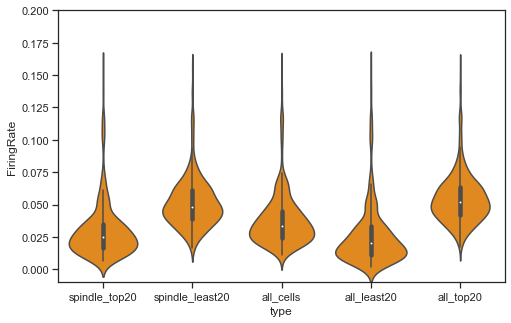

In [ ]:
df_temp = df_spindle_firing.melt(id_vars=['name'], var_name='type', value_name='FiringRate')
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("ticks")
plt.ylim(-0.01,0.2)
g=sns.violinplot(x="type", y="FiringRate",palette=['darkorange','darkorange','darkorange','darkorange'],linewidth=1.5,data=df_temp )
#if save_file:

### Percentage of spindle active and inactive cells not overlapping with top/least

In [ ]:
df_spindle_firing = pd.DataFrame()


for i, indDict in enumerate(data_list):
    if (len(indDict['spi_osc_data'])):
        temp_spi = []
        temp_least = []
        temp_spi = indDict["spindle_least20_diff_firing"][0]
        temp_least = indDict["least20_avg_firing"][0]
        temp_top =indDict["top20_avg_firing"][0]
        df_spindle_firing = df_spindle_firing.append(pd.DataFrame({'Fraction':[(len([d for d in temp_spi if d not in temp_least and d not in temp_top])/len(temp_spi)) *100], 
                                                             'name':indDict['mouseName'], 
                                                             'epochID': i}), ignore_index = True)

In [ ]:
df_spindle_firing

,Fraction,name,epochID
0,0.000000,250520_m18a,26
1,44.680851,250520_m18a,28
2,38.297872,250520_m18a,48
3,70.212766,250520_m18a,50
4,0.000000,250520_m18a,52
...,...,...,...
558,25.000000,210121_m24a,2006
559,50.000000,210121_m24a,2008
560,21.428571,210121_m24a,2011
561,14.285714,210121_m24a,2013


(0.0, 100.0)

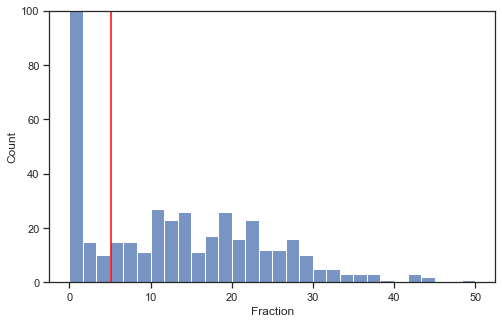

In [ ]:
sns.histplot(data = df_spindle_firing, x = "Fraction", bins=30)
plt.axvline(x=df_spindle_firing.Fraction.median(),
            color='red')
plt.ylim(0,100)